In [3]:
using PyPlot

INFO: Loading help data...


## Understanding Projected Gradients 

Consider the minimization of a smooth function $f$ over the convex set $\Omega$

$$
\min_{x\in\Omega} f(x)
$$

Let us assume that $\Omega$ allows us to come up with an explicit formula to compute the orthogonal projection

$$
P_{\Omega}(x) = \arg\min_{y\in\Omega} || x - y ||^2.
$$

We will see that the stationarity condition is equivalent to

$$
x^* = P_{\Omega} (x^* - s \nabla f(x^*)) \quad \forall s>0.
$$

Let us recall our previous example of minimizing a linear function on the unit ball (with interior). In this case the projection simply is

$$
P_{\Omega} (x) = \begin{cases} x, & || x || < \sqrt{2} \\ \frac{\sqrt{2} x}{\| x\|}, & \text{ else} \end{cases}.
$$


In [1]:
P(x) = (norm(x)^2 <= 2) ? x : sqrt(2)*x/norm(x)


P (generic function with 1 method)

The following code plots the objective function, constraints as well as gradients and projected search directions at three interesting points.

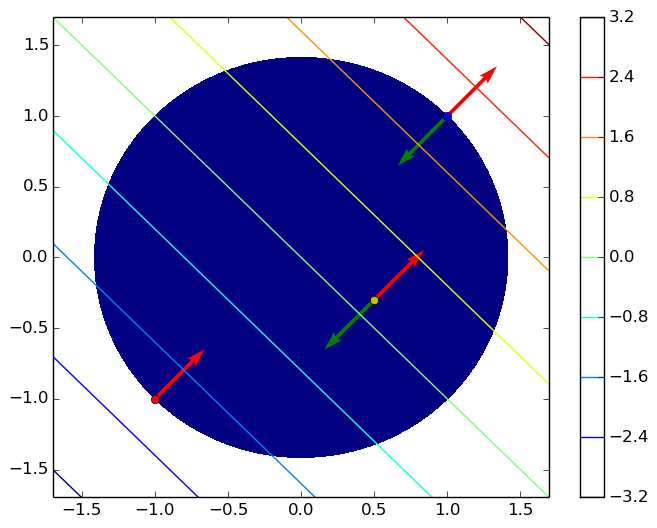

PyObject <matplotlib.quiver.Quiver object at 0x7f8b7db0abd0>

In [4]:
x = linspace(-1.2*sqrt(2),1.2*sqrt(2),101);
f(x) = x[1]+x[2]
df(x) = [1.;1;]
c(x) = x[1].^2 + x[2].^2 - 2
dc(x) = 2*x
fx = float([f([x[k];x[i];]) for k=1:length(x), i=1:length(x)])
cx = float([c([x[k];x[i];]) for k=1:length(x), i=1:length(x)])


contour(x,x,fx',10,hold=true)
colorbar()
contourf(x,x,cx',[0.0,0.0])
xs = [-1;-1.;]
plot(xs[1],xs[2],"or")
df1 = df(xs)
dc1 = dc(xs)
quiver(xs[1],xs[2],df1[1],df1[2],color="r",scale=10)
# quiver(xs[1],xs[2],-df1[1],-df1[2],color="y",scale=10)
Py = P(xs - df1)-xs;
quiver(xs[1],xs[2],Py[1],Py[2],color="y",scale=10)


xs = [.5;-0.3;]
plot(xs[1],xs[2],"oy")
df1 = df(xs)
quiver(xs[1],xs[2],df1[1],df1[2],color="r",scale=10)
quiver(xs[1],xs[2],-df1[1],-df1[2],color="g",scale=10)

xs = [1;1;]
plot(xs[1],xs[2],"ob")
df1 = df(xs)
dc1 = dc(xs)
quiver(xs[1],xs[2],df1[1],df1[2],color="r",scale=10)
quiver(xs[1],xs[2],-df1[1],-df1[2],color="g",scale=10)


The above figure shows the gradients (red) and projected gradients (green) at some interesting points. Note that at the minimizer $x^*=(-1,-1)^T$ the projected gradient vanishes.

## The Gradient Projection Method 

We have seen that stationarity is equivalent to 

$$
    x^* = P_{\Omega} (x^* - s \nabla f(x^*)) \quad \text{ for all } s > 0.
$$

The right hand side is the projected update a standard gradient descent method would produce. This motivates to extend our gradient descent method to a projected gradient descent method.

In [5]:
function pgd(f::Function,df::Function,x0,linesearch::Function,P::Function;maxIter=10,tol=1e-4,out=1)
    x   = copy(x0)
    his = zeros(maxIter,2)
    X   = zeros(maxIter,2)
    if out==1
        @printf "%s\t%6s\t\t%6s\n" "iter" "f(x)" "|df(x)|"
    end
    for iter=1:maxIter
        d = -df(x)
        t = linesearch(d,df(x))
        # here is the only change!
        Px = P(x+t*d)
        if norm(Px-x)<tol
            his = his[1:iter,:]
            X   = X[1:iter,:]
            break
        end
        
        x = P(x+t*d)
        his[iter,:] = [f(x) norm(df(x))];
        X[iter,:] = x;
        if out==1
            @printf "%4d\t%1.2e\t%1.2e\n" iter his[iter,1] his[iter,2]
        end
    end
    return x,his,X
end

pgd (generic function with 1 method)

Let us revisit the Cofee example from one of our first lectures. By now, our company became really successful. To keep all our promises, we now have to produce at least 1500 units of the Medium and 1800 units of the Espresso roast. 

The feasible set is

$$
    \Omega = \{ x \in R^2 \ | \ x_1 \geq 1800, x_2 \geq 1500 \}
$$

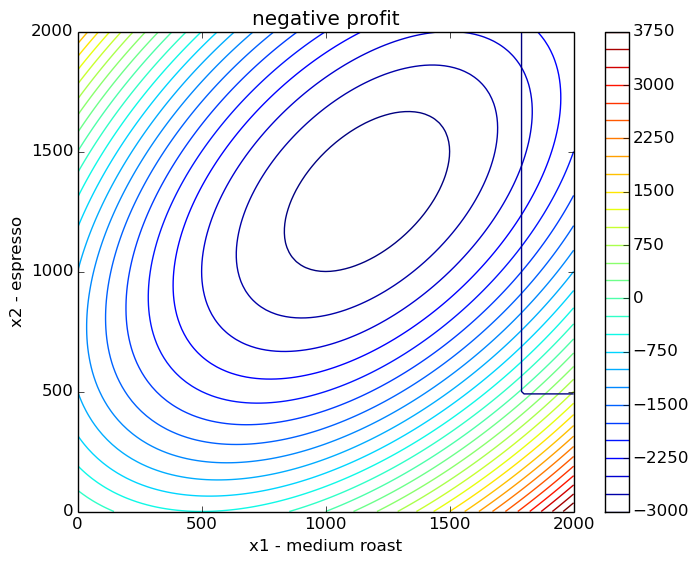

PyObject <matplotlib.contour.QuadContourSet instance at 0x7f8b7d86a098>

In [6]:
f(x1,x2) = 3*x1 + 5*x2 - (x1*(5-0.002*x1+ 0.001 *x2) + x2*(8-0.002*x2 + 0.001*x1))
c1(x1,x2) = 1.0*(-x1<=-1800)
c2(x1,x2) = 1.0*(-x2<=-500)
x = linspace(0,2000,101);
fc = [f(x[i],x[j]) for i=1:101,j=1:101];
cc = [c1(x[i],x[j]).*c2(x[i],x[j]) for i=1:101,j=1:101];

contour(x,x,fc',30,hold=true)
ylabel("x2 - espresso")
xlabel("x1 - medium roast")
title("negative profit")
colorbar()
contour(x,x,cc',1,linwidth=10)


Let us try to solve this problem with the projected gradient descent method and exact linesearch.

In [10]:
P(x) = max(x,[1800;500;])
df(x) = [x[1]/250 - x[2]/500 - 2; x[2]/250 - x[1]/500 - 2;]
Q = (1/500) *[2. -1; -1 2];
ls(d,df) = - dot(d,df)/dot(d,Q*d)


x0 = [100;500;]

xs,his,X = pgd(f,df,x0,ls,P;maxIter=100,tol=1e-10,out=1)


iter	  f(x)		|df(x)|
   1	2.35e+03	5.31e+00
   2	2.92e+03	3.16e+00
   3	3.13e+03	2.55e+00
   4	3.19e+03	2.41e+00
   5	3.20e+03	2.40e+00
   6	3.20e+03	2.40e+00
   7	3.20e+03	2.40e+00


([1800.0,1400.0],
8x2 Array{Float64,2}:
 2354.14  5.30941
 2921.41  3.16017
 3130.88  2.55325
 3193.28  2.41358
 3199.93  2.40015
 3200.0   2.4    
 3200.0   2.4    
    0.0   0.0    ,

8x2 Array{Float64,2}:
 1800.0   554.14
 1800.0  1121.41
 1800.0  1330.88
 1800.0  1393.28
 1800.0  1399.93
 1800.0  1400.0 
 1800.0  1400.0 
    0.0     0.0 )

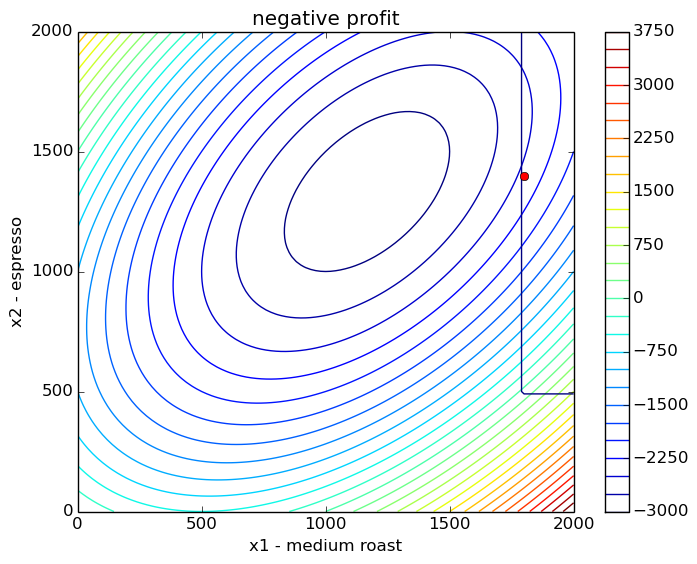

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8b7d0a6710>

In [11]:
contour(x,x,fc',30,hold=true)
ylabel("x2 - espresso")
xlabel("x1 - medium roast")
title("negative profit")
colorbar()
contour(x,x,cc',1,linwidth=10)
plot(xs[1],xs[2],"or")

In [13]:
println("The optimal production strategy is $(xs[1]) lb Medium and $(xs[2]) lb Espresso. ")
println("The expected profit is $(-f(x[1],x[2]))")

The optimal production strategy is 1800.0 lb Medium and 1399.9999999999998 lb Espresso. 
The expected profit is 59.19999999999999
